# Introduction

The following notebook it aimed at quantifying the movement of CDR domains in TCR variable regions between unbound (*apo*) and bound (*holo*) conformations. The *holo* conforomations in this case are TCRs bound to class I pMHC complexes.

In [1]:
import os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from python_pdb.aligners import align_pandas_structure
from python_pdb.comparisons import rmsd
from python_pdb.parsers import parse_pdb_to_pandas

from tcr_pmhc_structure_tools.imgt_numbering import assign_cdr_number
from tcr_pmhc_structure_tools.align import align_tcrs

In [2]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [3]:
DATA_DIR = '../data/tcr-pmhc'

In [4]:
NOISE_LEVEL = 0.5  # Å 

## Calculating RMSD between conformations

Now that the structures have been align, RMSD can be computed between all states of the same TCR. Comparions between the different *apo* and *holo* forms are also done so that these can be used as a control for the differences in *apo* to *holo* comparisons. This process is done two different ways. The first, termed framework alignment, computes the comparison between TCRs after aligning on the framework region of the proteins. This method captures the "global" conformational changes that these loops undergo including any combined rotations and deformations. The second method, termed loop alignment, does the same calculations as the first method, but after aligning the two loops being compared on their backbones. This method captures the deformation aspects of loops regardless of any hinging from the framework region.

In [5]:
def get_chain_assignments(file_path):
    chains = file_path.split('/')[-1].split('_')[1]
    
    return {chain: annotation 
            for chain, annotation in zip(chains, ['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2'][:len(chains)])}

def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()


In [6]:
def categorize_movement(rmsd: float) -> str:
    if rmsd < NOISE_LEVEL:
        return 'little movement'
    
    if NOISE_LEVEL <= rmsd < 1.0:
        return 'some movement'
    
    if 1.0 <= rmsd < 2.0:
        return 'movement'
    
    if 2.0 <= rmsd < 4.0:
        return 'large movement'
    
    if 4.0 <= rmsd:
        return 'significant movement'


movement_order = pd.CategoricalDtype(categories=['little movement', 'some movement', 'movement', 'large movement', 'significant movement'], ordered=True)

### Framework Alignment

In [7]:
groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(DATA_DIR):
    if not os.path.isdir(os.path.join(DATA_DIR, group)):
        continue
        
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]

    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        
        tcrs = []
        for path in (path1, path2):
            chains = get_chain_assignments(path)
            
            with open(os.path.join(DATA_DIR, group, path), 'r') as fh:
                structure_df = parse_pdb_to_pandas(fh.read())    
    
            structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: chains[chain_id])
            structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
            structure_df['backbone'] = structure_df['atom_name'].map(
                lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O')
            )

            tcr_df = structure_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
            tcrs.append(tcr_df)

        tcr1_df, tcr2_df = tcrs
        tcr1_df = align_tcrs(tcr1_df, tcr2_df)

        for chain_type, cdr_num in itertools.product(('alpha_chain', 'beta_chain'), (1, 2, 3)):
            tcr1_cdr_backbone = tcr1_df.query('cdr == @cdr_num and chain_type == @chain_type and backbone')
            tcr2_cdr_backbone = tcr2_df.query('cdr == @cdr_num and chain_type == @chain_type and backbone')
            
            groups.append(group)
            struct1s.append(path1)
            struct2s.append(path2)
            
            chain_types.append(chain_type)
            cdrs.append(cdr_num)
            
            rmsds.append(rmsd(get_coords(tcr1_cdr_backbone), get_coords(tcr2_cdr_backbone)))

7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb
6vrm_DEPA_holo.pdb 6vth_DE_apo.pdb
5c0a_DECA_holo.pdb 5hyj_DECA_holo.pdb
5c0a_DECA_holo.pdb 3utt_DECA_holo.pdb
5c0a_DECA_holo.pdb 3utp_DE_apo.pdb
5c0a_DECA_holo.pdb 5c07_DECA_holo.pdb
5c0a_DECA_holo.pdb 3uts_DECA_holo.pdb
5c0a_DECA_holo.pdb 5c0c_DEHF_holo.pdb
5c0a_DECA_holo.pdb 5c09_IJHF_holo.pdb
5c0a_DECA_holo.pdb 5c0b_IJHF_holo.pdb
5c0a_DECA_holo.pdb 5c08_DECA_holo.pdb
5hyj_DECA_holo.pdb 3utt_DECA_holo.pdb
5hyj_DECA_holo.pdb 3utp_DE_apo.pdb
5hyj_DECA_holo.pdb 5c07_DECA_holo.pdb
5hyj_DECA_holo.pdb 3uts_DECA_holo.pdb
5hyj_DECA_holo.pdb 5c0c_DEHF_holo.pdb
5hyj_DECA_holo.pdb 5c09_IJHF_holo.pdb
5hyj_DECA_holo.pdb 5c0b_IJHF_holo.pdb
5hyj_DECA_holo.pdb 5c08_DECA_holo.pdb
3utt_DECA_holo.pdb 3utp_DE_apo.pdb
3utt_DECA_holo.pdb 5c07_DECA_holo.pdb
3utt_DECA_holo.pdb 3uts_DECA_holo.pdb
3utt_DECA_holo.pdb 5c0c_DEHF_holo.pdb
3utt_DECA_holo.pdb 5c09_IJHF_holo.pdb
3utt_DECA_holo.pdb 5c0b_IJHF_holo.pdb
3utt_DECA_holo.pdb 5c08_DECA_holo.pdb
3utp_DE_apo.pdb 5c07_DECA_h

In [8]:
results_framework = pd.DataFrame(zip(groups, struct1s, struct2s, chain_types, cdrs, rmsds), columns=['group', 'struct1', 'struct2', 'chain_type', 'cdr', 'rmsd'])
results_framework

,group,struct1,struct2,chain_type,cdr,rmsd
0,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,alpha_chain,1,1.607441
1,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,alpha_chain,2,0.861686
2,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,alpha_chain,3,0.863015
3,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,beta_chain,1,0.587469
4,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,beta_chain,2,0.319182
...,...,...,...,...,...,...
1027,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlk_DECA_holo.pdb,2vlj_DECA_holo.pdb,alpha_chain,2,0.234306
1028,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlk_DECA_holo.pdb,2vlj_DECA_holo.pdb,alpha_chain,3,0.232080
1029,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlk_DECA_holo.pdb,2vlj_DECA_holo.pdb,beta_chain,1,0.261057
1030,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlk_DECA_holo.pdb,2vlj_DECA_holo.pdb,beta_chain,2,0.212512


In [9]:
results_framework['struct1_form'] = results_framework['struct1'].map(lambda path: path.split('.')[0].split('_')[-1])
results_framework['struct2_form'] = results_framework['struct2'].map(lambda path: path.split('.')[0].split('_')[-1])
results_framework['combined_structures'] = results_framework.apply(lambda row: '-'.join(sorted([row['struct1'], row['struct2']])), axis=1)
results_framework = results_framework.drop_duplicates(['combined_structures', 'cdr', 'chain_type'])

results_framework['comparison'] = results_framework['struct1_form'] + '-' + results_framework['struct2_form']
results_framework['comparison'] = results_framework['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

In [10]:
results_framework = results_framework.groupby(['group', 'comparison', 'cdr', 'chain_type'])['rmsd'].mean().reset_index()

In [11]:

results_framework['movement'] = results_framework['rmsd'].map(categorize_movement).astype(movement_order)

In [12]:
results_framework

,group,comparison,cdr,chain_type,rmsd,movement
0,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,1,alpha_chain,2.276638,large movement
1,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,1,beta_chain,0.770524,some movement
2,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,2,alpha_chain,0.935183,some movement
3,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,2,beta_chain,0.918362,some movement
4,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,3,alpha_chain,1.702314,movement
...,...,...,...,...,...,...
175,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,1,beta_chain,0.766135,some movement
176,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,2,alpha_chain,2.580519,large movement
177,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,2,beta_chain,0.894050,some movement
178,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,3,alpha_chain,1.956240,movement


## Loop Alignment

In [13]:
groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(DATA_DIR):
    if not os.path.isdir(os.path.join(DATA_DIR, group)):
        continue
        
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]

    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        
        tcrs = []
        for path in (path1, path2):
            chains = get_chain_assignments(path)
            
            with open(os.path.join(DATA_DIR, group, path), 'r') as fh:
                structure_df = parse_pdb_to_pandas(fh.read())    
    
            structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: chains[chain_id])
            structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
            structure_df['backbone'] = structure_df['atom_name'].map(
                lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O')
            )

            tcr_df = structure_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
            tcrs.append(tcr_df)

        tcr1_df, tcr2_df = tcrs

        for chain_type, cdr_num in itertools.product(('alpha_chain', 'beta_chain'), (1, 2, 3)):
            tcr1_cdr_backbone = tcr1_df.query('cdr == @cdr_num and chain_type == @chain_type and backbone')
            tcr2_cdr_backbone = tcr2_df.query('cdr == @cdr_num and chain_type == @chain_type and backbone')
			
            tcr2_cdr_backbone = align_pandas_structure(get_coords(tcr2_cdr_backbone), get_coords(tcr1_cdr_backbone), tcr2_cdr_backbone)
            
            groups.append(group)
            struct1s.append(path1)
            struct2s.append(path2)
            
            chain_types.append(chain_type)
            cdrs.append(cdr_num)
            
            rmsds.append(rmsd(get_coords(tcr1_cdr_backbone), get_coords(tcr2_cdr_backbone)))

7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb
6vrm_DEPA_holo.pdb 6vth_DE_apo.pdb
5c0a_DECA_holo.pdb 5hyj_DECA_holo.pdb
5c0a_DECA_holo.pdb 3utt_DECA_holo.pdb
5c0a_DECA_holo.pdb 3utp_DE_apo.pdb
5c0a_DECA_holo.pdb 5c07_DECA_holo.pdb
5c0a_DECA_holo.pdb 3uts_DECA_holo.pdb
5c0a_DECA_holo.pdb 5c0c_DEHF_holo.pdb
5c0a_DECA_holo.pdb 5c09_IJHF_holo.pdb
5c0a_DECA_holo.pdb 5c0b_IJHF_holo.pdb
5c0a_DECA_holo.pdb 5c08_DECA_holo.pdb
5hyj_DECA_holo.pdb 3utt_DECA_holo.pdb
5hyj_DECA_holo.pdb 3utp_DE_apo.pdb
5hyj_DECA_holo.pdb 5c07_DECA_holo.pdb
5hyj_DECA_holo.pdb 3uts_DECA_holo.pdb
5hyj_DECA_holo.pdb 5c0c_DEHF_holo.pdb
5hyj_DECA_holo.pdb 5c09_IJHF_holo.pdb
5hyj_DECA_holo.pdb 5c0b_IJHF_holo.pdb
5hyj_DECA_holo.pdb 5c08_DECA_holo.pdb
3utt_DECA_holo.pdb 3utp_DE_apo.pdb
3utt_DECA_holo.pdb 5c07_DECA_holo.pdb
3utt_DECA_holo.pdb 3uts_DECA_holo.pdb
3utt_DECA_holo.pdb 5c0c_DEHF_holo.pdb
3utt_DECA_holo.pdb 5c09_IJHF_holo.pdb
3utt_DECA_holo.pdb 5c0b_IJHF_holo.pdb
3utt_DECA_holo.pdb 5c08_DECA_holo.pdb
3utp_DE_apo.pdb 5c07_DECA_h

In [14]:
results_loop = pd.DataFrame(zip(groups, struct1s, struct2s, chain_types, cdrs, rmsds), columns=['group', 'struct1', 'struct2', 'chain_type', 'cdr', 'rmsd'])
results_loop

,group,struct1,struct2,chain_type,cdr,rmsd
0,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,alpha_chain,1,1.210386
1,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,alpha_chain,2,0.311221
2,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,alpha_chain,3,0.514866
3,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,beta_chain,1,0.233135
4,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,beta_chain,2,0.262128
...,...,...,...,...,...,...
1027,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlk_DECA_holo.pdb,2vlj_DECA_holo.pdb,alpha_chain,2,0.179874
1028,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlk_DECA_holo.pdb,2vlj_DECA_holo.pdb,alpha_chain,3,0.159360
1029,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlk_DECA_holo.pdb,2vlj_DECA_holo.pdb,beta_chain,1,0.143498
1030,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlk_DECA_holo.pdb,2vlj_DECA_holo.pdb,beta_chain,2,0.127633


In [15]:
results_loop['struct1_form'] = results_loop['struct1'].map(lambda path: path.split('.')[0].split('_')[-1])
results_loop['struct2_form'] = results_loop['struct2'].map(lambda path: path.split('.')[0].split('_')[-1])
results_loop['combined_structures'] = results_loop.apply(lambda row: '-'.join(sorted([row['struct1'], row['struct2']])), axis=1)
results_loop = results_loop.drop_duplicates(['combined_structures', 'cdr', 'chain_type'])

results_loop['comparison'] = results_loop['struct1_form'] + '-' + results_loop['struct2_form']
results_loop['comparison'] = results_loop['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)
results_loop = results_loop.groupby(['group', 'comparison', 'cdr', 'chain_type'])['rmsd'].mean().reset_index()

In [16]:
results_loop['movement'] = results_loop['rmsd'].map(categorize_movement).astype(movement_order)
results_loop

,group,comparison,cdr,chain_type,rmsd,movement
0,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,1,alpha_chain,1.371636,movement
1,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,1,beta_chain,0.131662,little movement
2,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,2,alpha_chain,0.214588,little movement
3,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,2,beta_chain,0.242671,little movement
4,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,3,alpha_chain,1.356941,movement
...,...,...,...,...,...,...
175,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,1,beta_chain,0.113602,little movement
176,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,2,alpha_chain,1.082925,movement
177,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,2,beta_chain,0.201732,little movement
178,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,3,alpha_chain,1.475480,movement


# Visualizing and analysing the results

## Measuring the distance between apo and holo confomations

Since RMSD was calculated for all pairings of the same TCR, the apo-holo (or holo-apo) comparisons were selected.

### Framework Alignment

count      mean       std       min       25%       50%  \
chain_type  cdr                                                            
alpha_chain 1     18.0  1.412228  0.670181  0.590867  0.736539  1.378229   
            2     18.0  1.168239  0.519295  0.599475  0.831431  0.971132   
            3     18.0  2.209238  1.216582  0.628045  1.249656  1.894267   
beta_chain  1     18.0  0.806213  0.290987  0.352317  0.594133  0.768330   
            2     18.0  0.903724  0.817169  0.319182  0.484989  0.784928   
            3     18.0  1.569937  0.876325  0.484300  0.952874  1.204311   

                      75%       max  
chain_type  cdr                      
alpha_chain 1    1.756483  2.637263  
            2    1.341400  2.580519  
            3    2.897261  4.571959  
beta_chain  1    1.052910  1.295438  
            2    0.912284  3.914915  
            3    2.083028  3.363540

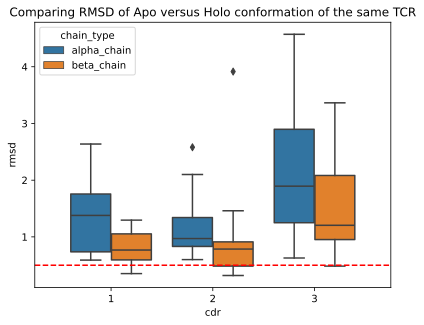

In [17]:
sns.boxplot(data=results_framework.query("comparison == 'apo-holo'"), y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of Apo versus Holo conformation of the same TCR')

x = np.linspace(-0.75, 2.75)
y = np.repeat(NOISE_LEVEL, len(x))

plt.plot(x, y, '--r')
plt.xlim(-0.75, 2.75)

results_framework.query("comparison == 'apo-holo'").groupby(['chain_type', 'cdr'])['rmsd'].describe()

In [18]:
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_framework.query("comparison == 'apo-holo'").groupby(['chain_type', 'cdr'])]
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=30.637558047344044, pvalue=1.1044190261084214e-05)


In [19]:
combos = [(((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y))
          for ((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y) in itertools.combinations(treatments, 2)
          if cdr_x == cdr_y]

chain_xs = []
cdr_xs = []
chain_ys = []
cdr_ys = []
statistics = []
p_vals = []

for ((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    chain_xs.append(chain_x)
    cdr_xs.append(cdr_x)
    chain_ys.append(chain_y)
    cdr_ys.append(cdr_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'chain_type_x': chain_xs,
    'cdr_x': cdr_xs,
    'chain_type_y': chain_ys,
    'cdr_y': cdr_ys,
    'statistic': statistics,
    'p_val': p_vals,
})

,chain_type_x,cdr_x,chain_type_y,cdr_y,statistic,p_val
0,alpha_chain,1,beta_chain,1,2.815835,0.004865
1,alpha_chain,2,beta_chain,2,2.404534,0.016193
2,alpha_chain,3,beta_chain,3,1.518653,0.128850


In [20]:
treatments = [(cdr, df['rmsd'].to_numpy()) for cdr, df in results_framework.query("comparison == 'apo-holo'").groupby('cdr')]

cdr_xs = []
cdr_ys = []

statistics = []
p_vals = []

for (cdr_x, sample_x), (cdr_y, sample_y) in itertools.combinations(treatments, 2):
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    
    cdr_xs.append(cdr_x)
    cdr_ys.append(cdr_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'cdr_x': cdr_xs,
    'cdr_y': cdr_ys,
    'statistic': statistics,
    'p_val': p_vals,
})

,cdr_x,cdr_y,statistic,p_val
0,1,2,0.664475,0.506386
1,1,3,-3.389949,0.000699
2,2,3,-3.862965,0.000112


The figure above shows there appears to be an increase in the movement of CDR3 compared to CDR1 and CDR2 and that the alpha chain has more movement than the beta chain of the TCR.

<Axes: ylabel='count'>

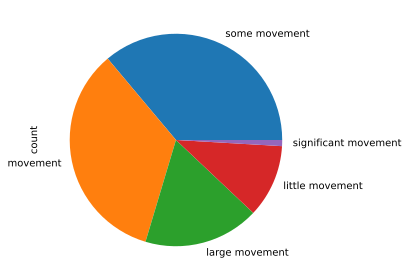

In [21]:
results_framework.query("comparison == 'apo-holo'")['movement'].value_counts().plot.pie()

### Loop Alignment

count      mean       std       min       25%       50%  \
chain_type  cdr                                                            
alpha_chain 1     18.0  0.494018  0.354435  0.148173  0.268908  0.391226   
            2     18.0  0.499824  0.350288  0.214588  0.255036  0.334554   
            3     18.0  1.309151  0.679560  0.321354  0.692386  1.325095   
beta_chain  1     18.0  0.269487  0.198688  0.113602  0.145369  0.185635   
            2     18.0  0.310849  0.199439  0.146389  0.180239  0.231965   
            3     18.0  0.988858  0.698487  0.193641  0.414155  0.794968   

                      75%       max  
chain_type  cdr                      
alpha_chain 1    0.505869  1.371636  
            2    0.668683  1.363055  
            3    1.630650  2.536349  
beta_chain  1    0.325133  0.832734  
            2    0.333987  0.831726  
            3    1.354675  2.503292

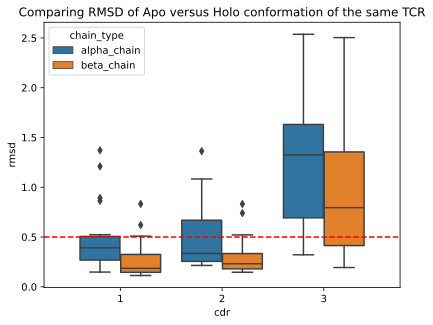

In [22]:
sns.boxplot(data=results_loop.query("comparison == 'apo-holo'"), y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of Apo versus Holo conformation of the same TCR')

x = np.linspace(-0.75, 2.75)
y = np.repeat(NOISE_LEVEL, len(x))

plt.plot(x, y, '--r')
plt.xlim(-0.75, 2.75)

results_loop.query("comparison == 'apo-holo'").groupby(['chain_type', 'cdr'])['rmsd'].describe()

In [23]:
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_loop.query("comparison == 'apo-holo'").groupby(['chain_type', 'cdr'])]
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=47.75070789443879, pvalue=3.993402077932266e-09)


In [24]:
combos = [(((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y))
          for ((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y) in itertools.combinations(treatments, 2)
          if cdr_x == cdr_y]

chain_xs = []
cdr_xs = []
chain_ys = []
cdr_ys = []
statistics = []
p_vals = []

for ((chain_x, cdr_x), sample_x), ((chain_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    chain_xs.append(chain_x)
    cdr_xs.append(cdr_x)
    chain_ys.append(chain_y)
    cdr_ys.append(cdr_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'chain_type_x': chain_xs,
    'cdr_x': cdr_xs,
    'chain_type_y': chain_ys,
    'cdr_y': cdr_ys,
    'statistic': statistics,
    'p_val': p_vals,
})

,chain_type_x,cdr_x,chain_type_y,cdr_y,statistic,p_val
0,alpha_chain,1,beta_chain,1,2.815835,0.004865
1,alpha_chain,2,beta_chain,2,2.467811,0.013594
2,alpha_chain,3,beta_chain,3,1.423737,0.154523


In [25]:
treatments = [(cdr, df['rmsd'].to_numpy()) for cdr, df in results_loop.query("comparison == 'apo-holo'").groupby('cdr')]

cdr_xs = []
cdr_ys = []

statistics = []
p_vals = []

for (cdr_x, sample_x), (cdr_y, sample_y) in itertools.combinations(treatments, 2):
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    
    cdr_xs.append(cdr_x)
    cdr_ys.append(cdr_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'cdr_x': cdr_xs,
    'cdr_y': cdr_ys,
    'statistic': statistics,
    'p_val': p_vals,
})

,cdr_x,cdr_y,statistic,p_val
0,1,2,-0.664475,5.063863e-01
1,1,3,-5.293276,1.201443e-07
2,2,3,-5.056768,4.264214e-07


The figure above shows there appears to be an increase in the movement of CDR3 compared to CDR1 and CDR2 and that the alpha chain has more movement than the beta chain of the TCR.

<Axes: ylabel='count'>

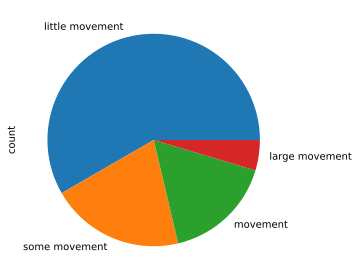

In [26]:
results_loop.query("comparison == 'apo-holo'")['movement'].value_counts().plot.pie()

## Comparison of *apo*-*holo* to *holo*-*holo* conformational changes

The following analysis aims to ascertain whether there is notable movement in the CDR domains between the *apo* and *holo* conformations, using *holo*-*holo* differences as controls.

### Framework Alignment

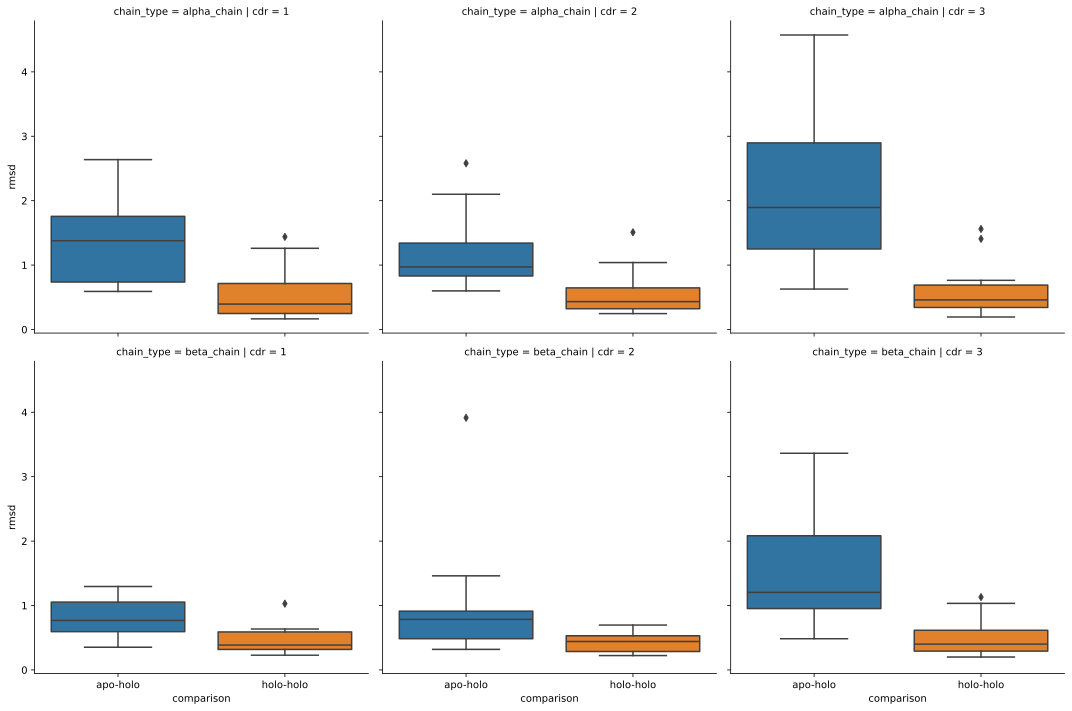

In [27]:
sns.catplot(results_framework.sort_values(['comparison', 'chain_type', 'cdr']),
            x='comparison',
            y='rmsd',
            col='cdr',
            row='chain_type',
            kind='box')

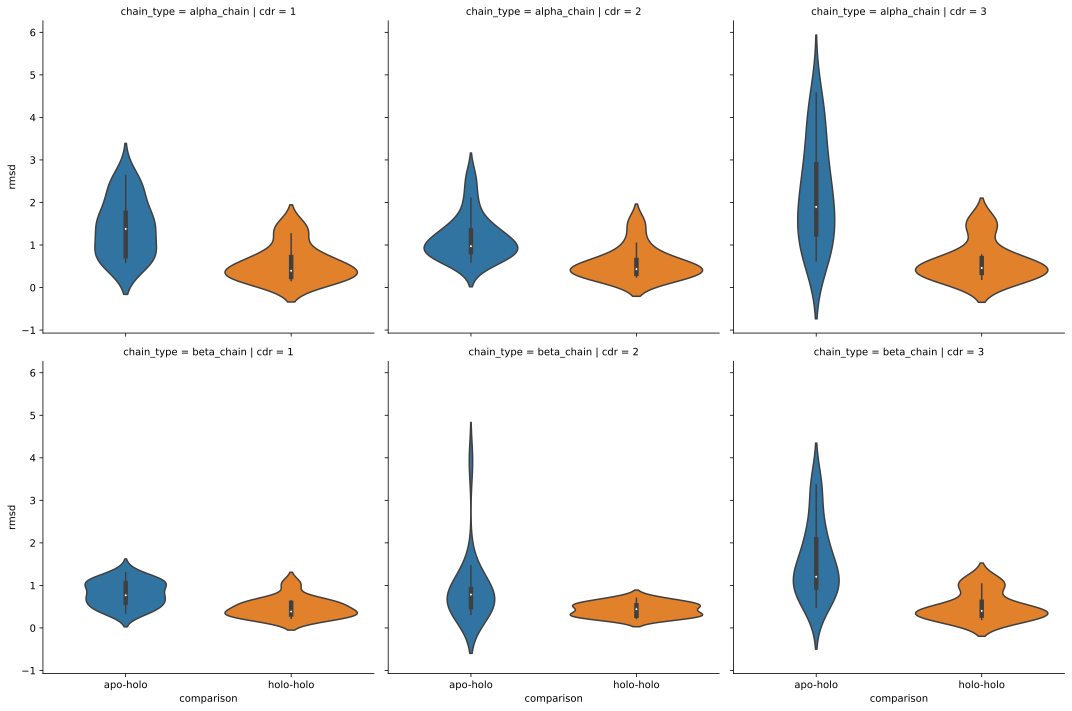

In [28]:
sns.catplot(results_framework.sort_values(['comparison', 'chain_type', 'cdr']),
            x='comparison',
            y='rmsd',
            col='cdr',
            row='chain_type',
            kind='violin')

In [29]:
treatment_options = ['comparison', 'chain_type', 'cdr']
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_framework.groupby(treatment_options)]
treatments
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=89.8613566605278, pvalue=1.7747589183733027e-14)


In [30]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    chain_type_x = pairing[0][0][1]
    cdr_x = pairing[0][0][2]
    chain_type_y = pairing[1][0][1]
    cdr_y = pairing[1][0][2]
    
    if (chain_type_x, cdr_x) == (chain_type_y, cdr_y):
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

0.008333333333333333


,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-holo,alpha_chain,1,holo-holo,alpha_chain,1,3.471337,0.000518,True
1,apo-holo,alpha_chain,2,holo-holo,alpha_chain,2,3.429003,0.000606,True
2,apo-holo,alpha_chain,3,holo-holo,alpha_chain,3,4.064004,0.000048,True
3,apo-holo,beta_chain,1,holo-holo,beta_chain,1,3.217337,0.001294,True
4,apo-holo,beta_chain,2,holo-holo,beta_chain,2,2.497669,0.012501,False
5,apo-holo,beta_chain,3,holo-holo,beta_chain,3,3.852337,0.000117,True


In [31]:
combos = list(itertools.combinations(treatments, 2))

significance_level = 0.05 / len(combos)

statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-holo,alpha_chain,1,apo-holo,alpha_chain,2,0.854242,0.392971,False
1,apo-holo,alpha_chain,1,apo-holo,alpha_chain,3,-2.151425,0.031443,False
2,apo-holo,alpha_chain,1,apo-holo,beta_chain,1,2.815835,0.004865,False
3,apo-holo,alpha_chain,1,apo-holo,beta_chain,2,2.689281,0.007161,False
4,apo-holo,alpha_chain,1,apo-holo,beta_chain,3,-0.284747,0.775838,False
...,...,...,...,...,...,...,...,...,...
61,holo-holo,alpha_chain,3,holo-holo,beta_chain,2,0.461880,0.644167,False
62,holo-holo,alpha_chain,3,holo-holo,beta_chain,3,0.461880,0.644167,False
63,holo-holo,beta_chain,1,holo-holo,beta_chain,2,0.288675,0.772830,False
64,holo-holo,beta_chain,1,holo-holo,beta_chain,3,0.057735,0.953960,False


The analysis of the plots and statistical tests shows that there is a statistically significant (p-value: 0.05) difference between the target and controls (as seen by the results of the Kruskal-Wallis test) but it also shows that there is a significant difference between the two controls.

### Loop Alignment

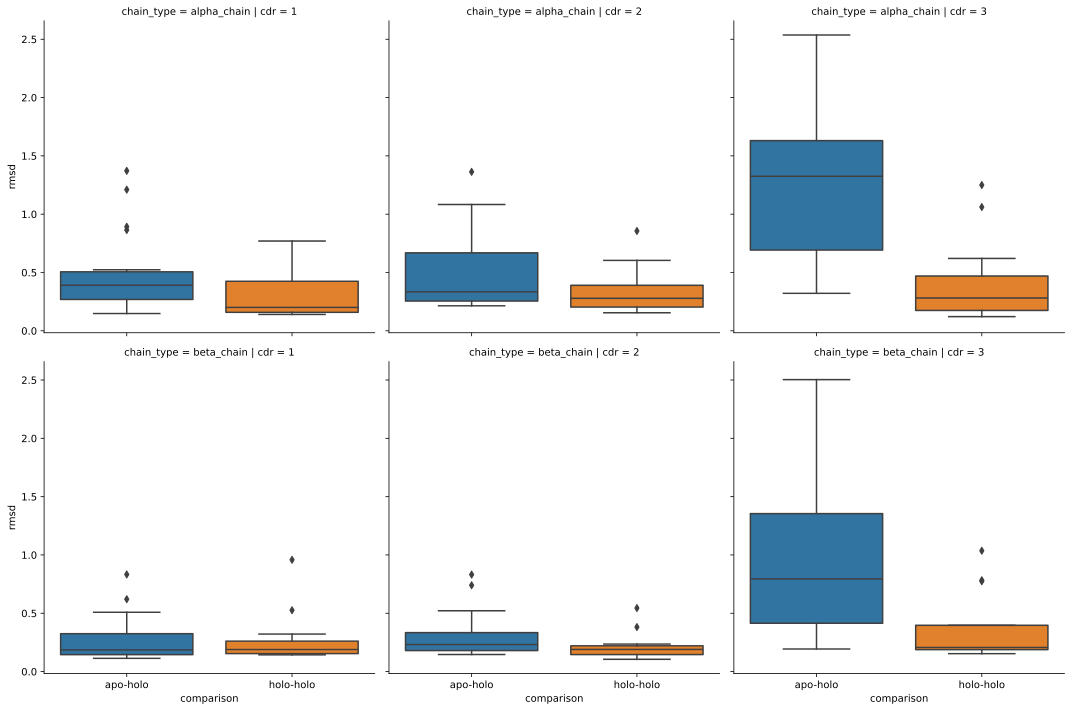

In [32]:
sns.catplot(results_loop.sort_values(['comparison', 'chain_type', 'cdr']),
            x='comparison',
            y='rmsd',
            col='cdr',
            row='chain_type',
            kind='box')

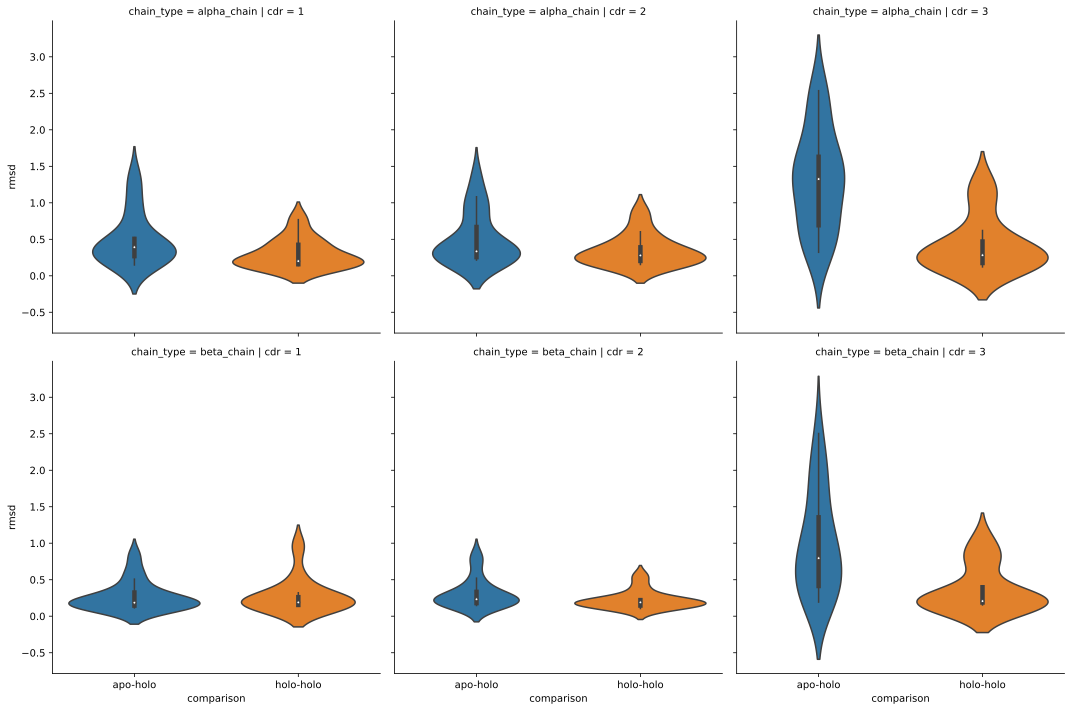

In [33]:
sns.catplot(results_loop.sort_values(['comparison', 'chain_type', 'cdr']),
            x='comparison',
            y='rmsd',
            col='cdr',
            row='chain_type',
            kind='violin')

In [34]:
treatment_options = ['comparison', 'chain_type', 'cdr']
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_loop.groupby(treatment_options)]
treatments
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=70.13615715162666, pvalue=1.1509892617671173e-10)


In [35]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    chain_type_x = pairing[0][0][1]
    cdr_x = pairing[0][0][2]
    chain_type_y = pairing[1][0][1]
    cdr_y = pairing[1][0][2]
    
    if (chain_type_x, cdr_x) == (chain_type_y, cdr_y):
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

0.008333333333333333


,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-holo,alpha_chain,1,holo-holo,alpha_chain,1,1.905002,0.056780,False
1,apo-holo,alpha_chain,2,holo-holo,alpha_chain,2,1.608668,0.107689,False
2,apo-holo,alpha_chain,3,holo-holo,alpha_chain,3,3.767670,0.000165,True
3,apo-holo,beta_chain,1,holo-holo,beta_chain,1,-0.381000,0.703203,False
4,apo-holo,beta_chain,2,holo-holo,beta_chain,2,1.608668,0.107689,False
5,apo-holo,beta_chain,3,holo-holo,beta_chain,3,3.090336,0.001999,True


In [36]:
combos = list(itertools.combinations(treatments, 2))

significance_level = 0.05 / len(combos)

statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-holo,alpha_chain,1,apo-holo,alpha_chain,2,0.221470,0.824726,False
1,apo-holo,alpha_chain,1,apo-holo,alpha_chain,3,-3.986464,0.000067,True
2,apo-holo,alpha_chain,1,apo-holo,beta_chain,1,2.815835,0.004865,False
3,apo-holo,alpha_chain,1,apo-holo,beta_chain,2,2.246341,0.024682,False
4,apo-holo,alpha_chain,1,apo-holo,beta_chain,3,-2.183063,0.029031,False
...,...,...,...,...,...,...,...,...,...
61,holo-holo,alpha_chain,3,holo-holo,beta_chain,2,1.616581,0.105969,False
62,holo-holo,alpha_chain,3,holo-holo,beta_chain,3,0.519615,0.603332,False
63,holo-holo,beta_chain,1,holo-holo,beta_chain,2,0.577350,0.563703,False
64,holo-holo,beta_chain,1,holo-holo,beta_chain,3,-1.039230,0.298698,False


The analysis of the plots and statistical tests shows that there is a statistically significant (p-value: 0.05) difference between the target and controls (as seen by the results of the Kruskal-Wallis test) but it also shows that there is a significant difference between the two controls.